# Time dependent Bayesian Optimization

In this example we demonstrate time dependent optimization. In this case we are not
only interested in finding an optimum point in input space, but also maintain the
ideal point over time.

In [1]:
# set values if testing
import os
import time
import warnings
import torch
from matplotlib import pyplot as plt
from tqdm import trange
from xopt.generators.bayesian import TDUpperConfidenceBoundGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt import Xopt

SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
N_STEPS = 1 if SMOKE_TEST else 300
warnings.filterwarnings("ignore")

## Time dependent test problem
Optimization is carried out over a single variable `x`. The test function is a simple
 quadratic, with a minimum location that drifts and changes as a function of time `t`.

Define test functions

In [2]:
# location of time dependent minimum
def k(t_):
    return torch.where(
        t_ < 50, 0.25 * torch.sin(t_ * 6 / 10.0) + 0.1e-2 * t_, -1.5e-2 * (t_ - 50.0)
    )


# define function in time and position space
def g(x_, t_):
    return (x_ - k(t_)) ** 2


# create callable function for Xopt
def f(inputs):
    x_ = inputs["x"]
    current_time = time.time()
    t_ = current_time - start_time
    y_ = g(x_, torch.tensor(t_))

    return {"y": float(y_), "time": float(current_time)}

## Define Xopt objects including optimization algorithm

In [3]:
variables = {"x": [-1, 1]}
objectives = {"y": "MINIMIZE"}

vocs = VOCS(variables=variables, objectives=objectives)

evaluator = Evaluator(function=f)


            Xopt
________________________________
Version: 2.4.3.dev0+gc905ef24.d20241002
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.f
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  added_time: 0.1
  beta: 0.01
  computation_time: null
  custom_objective: null
  fixed_features: null
  forgetting_time: 20.0
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: time_dependent
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
    use_spectral_mixture_kernel: true
  log_transform_acquisition_function: false
  max_travel_distances:
  - 0.1
  memory_length: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: time_dependent_upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  target_prediction_time: null
  turbo_controller: null
  use_cu

## Run optimization

In [4]:
generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.01,
    added_time=0.1,
    forgetting_time=20.0,
)
generator.n_monte_carlo_samples = N_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.max_travel_distances = [0.1]

start_time = time.time()

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X.random_evaluate(1)

for _ in trange(N_STEPS):
    # note that in this example we can ignore warnings if computation time is greater
    # than added time
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        X.step()
        time.sleep(0.1)

100%|██████████| 300/300 [03:26<00:00,  1.45it/s]


## Visualize GP model of objective function and plot trajectory

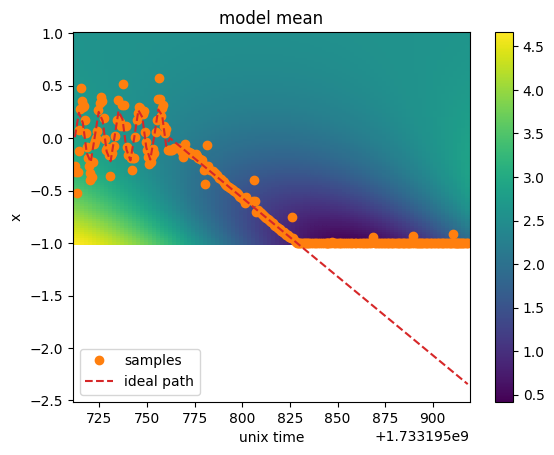

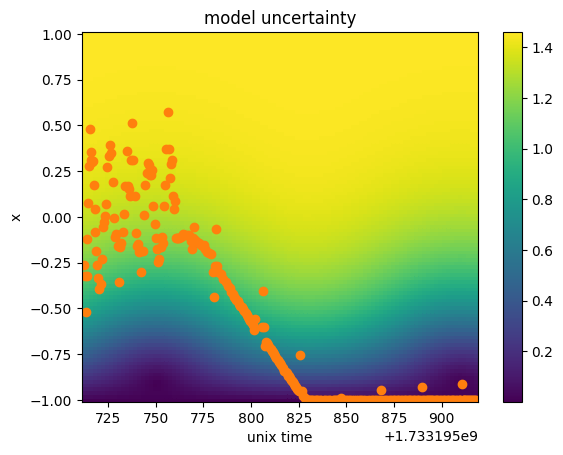

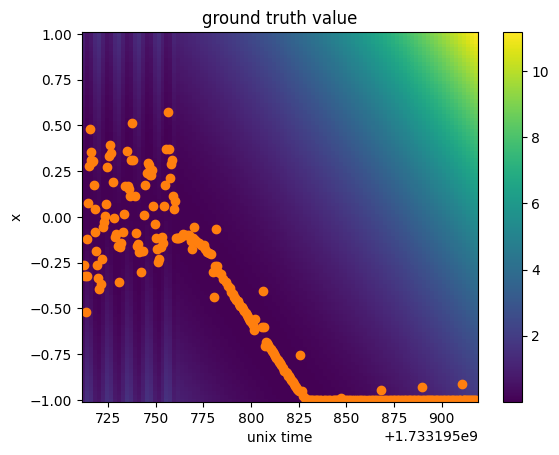

In [5]:
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

model = X.generator.model
n = 100
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

tt, xx = tt.numpy(), xx.numpy()

# NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = g(gp_pts.T[0], gp_pts.T[1] - start_time)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.set_title("model mean")
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    c = ax.pcolor(tt, xx, mean.reshape(n, n))
    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1", label="samples")

    ax.plot(t, k(t - start_time), "C3--", label="ideal path", zorder=10)
    ax.legend()
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    ax2.set_title("model uncertainty")
    ax2.set_xlabel("unix time")
    ax2.set_ylabel("x")
    c = ax2.pcolor(tt, xx, std.reshape(n, n))
    fig2.colorbar(c)

    fig3, ax3 = plt.subplots()
    ax3.set_title("ground truth value")
    ax3.set_xlabel("unix time")
    ax3.set_ylabel("x")
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n, n))
    fig3.colorbar(c)

    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1")
    ax3.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1")

## plot the acquisition function

205.938800573349


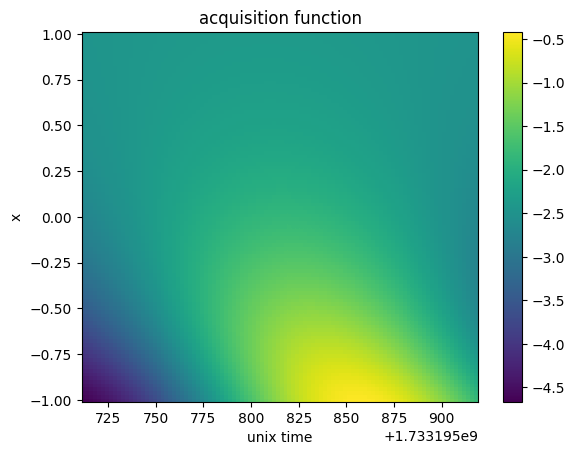

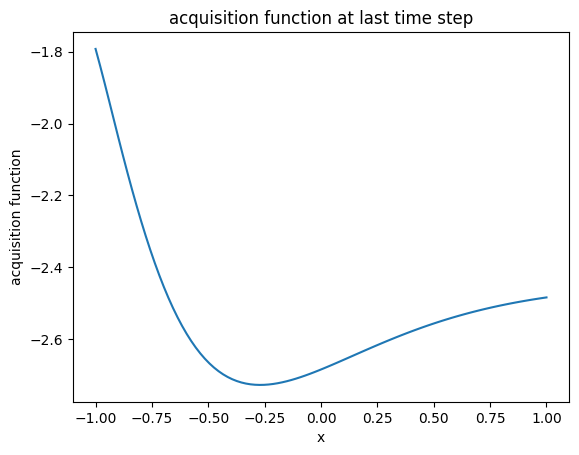

In [6]:
# note that target time is only updated during the generate call
target_time = X.generator.target_prediction_time
print(target_time - start_time)
my_acq_func = X.generator.get_acquisition(model)

with torch.no_grad():
    acq_pts = x.unsqueeze(-1).unsqueeze(-1)
    full_acq = my_acq_func.acq_func(gp_pts.unsqueeze(1))
    fixed_acq = my_acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(tt, xx, full_acq.reshape(n, n))
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    ax.set_title("acquisition function")
    fig.colorbar(c)

    fi2, ax2 = plt.subplots()
    ax2.plot(x.flatten(), fixed_acq.flatten())
    ax2.set_xlabel("x")
    ax2.set_ylabel("acquisition function")
    ax2.set_title("acquisition function at last time step")

## Run Time Dependent BO with Model Caching
Instead of retraining the GP model hyperparameters at every step, we can instead hold
on to previously determined model parameters by setting
`use_catched_hyperparameters=True` in the model constructor. This reduces the time
needed to make decisions, leading to faster feedback when addressing time-critical
optimization tasks. However,  this can come at the cost of model accuracy when the
target function changes behavior (change in lengthscale for example).

In [6]:
generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.01,
    added_time=0.1,
    forgetting_time=20.0,
)
generator.n_monte_carlo_samples = N_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.max_travel_distances = [0.1]

start_time = time.time()

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X.random_evaluate(1)

for i in trange(300):
    # note that in this example we can ignore warnings if computation time is greater
    # than added time
    if i == 50:
        X.generator.gp_constructor.use_cached_hyperparameters = True

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        X.step()
        time.sleep(0.1)

In [ ]:
# plot total computation time
ax = X.generator.computation_time.sum(axis=1).plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("total BO computation time (s)")

In [ ]:
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

model = X.generator.model
n = 100
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

tt, xx = tt.numpy(), xx.numpy()

# NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = g(gp_pts.T[0], gp_pts.T[1] - start_time)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.set_title("model mean")
    ax.set_xlabel("unix time")
    ax.set_ylabel("x")
    c = ax.pcolor(tt, xx, mean.reshape(n, n))
    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1", label="samples")

    ax.plot(t, k(t - start_time), "C3--", label="ideal path", zorder=10)
    ax.legend()
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    ax2.set_title("model uncertainty")
    ax2.set_xlabel("unix time")
    ax2.set_ylabel("x")
    c = ax2.pcolor(tt, xx, std.reshape(n, n))
    fig2.colorbar(c)

    fig3, ax3 = plt.subplots()
    ax3.set_title("ground truth value")
    ax3.set_xlabel("unix time")
    ax3.set_ylabel("x")
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n, n))
    fig3.colorbar(c)

    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1")
    ax3.plot(data["time"].to_numpy(), data["x"].to_numpy(), "oC1")